<a href="https://colab.research.google.com/github/ritwikraha/Open-Generative-Fill/blob/main/experiments/sam_owlvit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Imports

In [1]:
import requests
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from transformers import SamModel, SamProcessor
from transformers import OwlViTProcessor, OwlViTForObjectDetection

## Dog

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
image_url = "https://i.imgur.com/CiAbKbS.jpeg"
raw_image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
image = raw_image.resize((512, 512))

prompt = "dog"

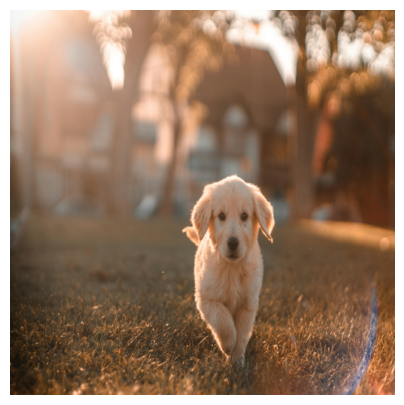

In [4]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

## OWL-ViT

In [9]:
owl_vit_model_id = "google/owlvit-base-patch32"
processor = OwlViTProcessor.from_pretrained(owl_vit_model_id)
model = OwlViTForObjectDetection.from_pretrained(owl_vit_model_id).to(device)

In [12]:
text_queries = ["dog"]
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size]).to(device)
    results = processor.post_process_object_detection(
        outputs,
        threshold=0.1,
        target_sizes=target_sizes
    )[0]

boxes = results["boxes"].tolist()

In [16]:
boxes

[[232.09947204589844, 216.47695922851562, 353.798095703125, 476.7342224121094]]

In [17]:
model.to("cpu")
del model
torch.cuda.empty_cache()

## Segment Anything

In [18]:
sam_model_id = "facebook/sam-vit-base"
model = SamModel.from_pretrained(sam_model_id).to(device)
processor = SamProcessor.from_pretrained(sam_model_id)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [19]:
input_boxes = [boxes]

inputs = processor(image, input_boxes=input_boxes, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

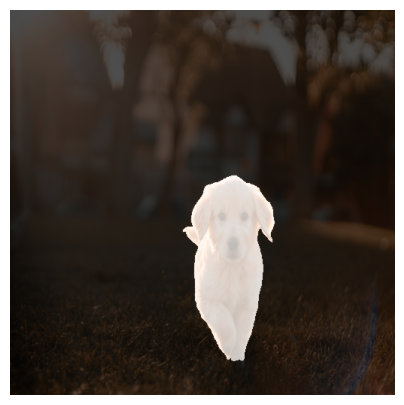

In [20]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.imshow(masks[0][0][0, :, :], alpha=0.7, cmap="gray")
plt.axis("off")
plt.show()